In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 

import tensorflow as tf 
import keras 
from keras import layers
df = pd.read_csv("../datasets/manipulation/6.csv")
df.head()
X = df.drop(["Price"], axis=1)
y = df["Price"]

In [ ]:
correlations = df.corr(numeric_only=True)
correlations

In [ ]:
#this doesnt finish for some reason, just executes forever

from skfeature.function.similarity_based import fisher_score

# get the fisher's score rankings 
ranks = fisher_score.fisher_score(X.values, y.values)

# create a pandas DataFrame for easier interpretation
feat_importances = pd.Series(ranks, X.columns)
feat_importances.plot(kind='barh')

# how to interpret -> low score means the effect of this field is not large in the dataset
# => typically means other columns in the dataset have similar correlations, 
# therefore making this particular column not so useful since other columns 
# already fill this role for this correlation

# Fisher's score studies the variance of the data -> statistical significance'

# based on Fisher's score:
# num_rooms is not important at all, and num_people has minor importance in this data
# but ave_monthly_income is quite powerful based on Fisher's score

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on target variable
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

# step 2, split the temporary data in HALF (0.5) => 15% test and 15% validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [8]:
# create neural network

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# save the amount of support variables into a helper variable
# so we don't have to update the input_shape all the time
variable_amount = len(X.columns)

# create callbacks and place them into a parameter list
# NOTE! if you get PermissionError while training the model,
# just try training it again
mc = ModelCheckpoint('best_model_regression1_energybill.keras', monitor='val_loss', mode='min', save_best_only=True)

# if you use multiple callbacks (EarlyStoppin, ReduceLROnPlateau etc.)
# add them to this same list
callback_list = [mc]

# let's try some common optimization approaches

# neural networks often need at least a normalization layer
# so that it updates all weight values fairly 
# typically the original dataset has various scales of numbers
# which confuses neural network while it's training itself
# luckily we have the BatchNormalization -layer in keras!

# regularization is often beneficial in neural networks
# but it's usually better to apply this a bit later
# once you know approximately a working neural network structure for your data
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dropout(0.1),
        layers.Dense(10, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(1)
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer='adam', loss='mse')

# common tips on how to change neural network structure if your metrics are not good:
#####################################################################################
# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523 (2.04 KB)

 Trainable params: 499 (1.95 KB)

 Non-trainable params: 24 (96.00 B)

In [9]:
model.fit(x=X_train, y=y_train, epochs=1200, validation_data=(X_val, y_val), callbacks=callback_list)

Epoch 1/1200
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 569549888.0000 - val_loss: 344298784.0000
Epoch 2/1200
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 360024320.0000 - val_loss: 237325776.0000
Epoch 3/1200
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 306316000.0000 - val_loss: 227081808.0000
Epoch 4/1200
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 296103072.0000 - val_loss: 222057456.0000
Epoch 5/1200
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 292122624.0000 - val_loss: 219089904.0000
Epoch 6/1200
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 285257536.0000 - val_loss: 215882080.0000
Epoch 7/1200
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 285310336.0000 - val_loss: 214174224.0000
Epoch 8/1200
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 282201952.0000 - val_loss: 212405280.0000
Epoch 9/1200
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 276590944.0000 - val_loss: 209142176.0000
Epoch 10/1200
379/379 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - los

<Axes: >

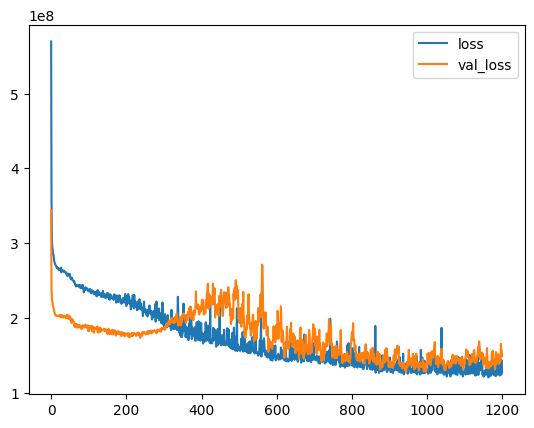

In [10]:
# let's use pandas for this (easy code)
# try to look if the model is actually training 
# => the error is going downwards
# if using validation data, you get two lines
# in this case, see if the lines follow a similar trend 
# (they don't always overlap with complex data, the trend is more important)
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [12]:
from keras.models import load_model
model = load_model("best_model_regression1_energybill.keras")

In [13]:
# compare the final model loss/evaluation values
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
140569488.0

Train data evaluation:
13080919040.0


In [14]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step


,Test True Y,Model Predictions
0,6272,7118.95
1,11604,10626.56
2,11726,25507.42
3,10036,9141.24
4,5645,6936.23
...,...,...
2591,862,12801.06
2592,53521,43961.41
2593,22266,50271.48
2594,7527,16061.16


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

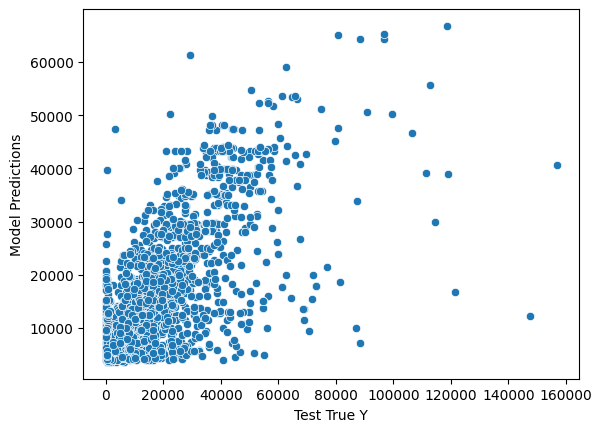

In [15]:
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

In [16]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
7215.21 $

MSE
140569424.0 $^2

RMSE:
11856.2 $

R-squared:
0.47

Explained variance score:
0.47


/tmp/ipykernel_108114/3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


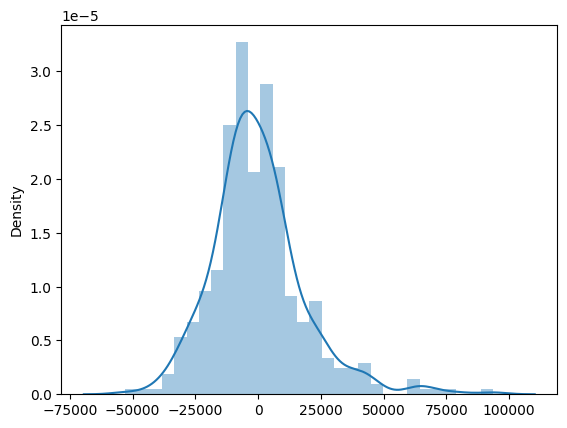

In [17]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()